<h1>IBM Data Science Capstone - Final Assignment</h1>

<h3>Due to recent political unrests, many US citizens are looking into the possibility of moving to Canada. 
    Here, we will look into which neighborhood in Toronto is ideal for those who currently live in Manhattan neighborhood by 
    comparing the top 10 most common venues in each neighborhood.
</h3>

<b><i> **Most of the codes are from Capstone module. Some modifications and additions added to demonstrate my learnings. </i></b>


## Step 1: import libraries


In [1]:
import numpy as np
import pandas as pd
! pip install folium==0.5.0
import folium # map rendering library
import requests
from sklearn.cluster import KMeans
import scipy.stats as ss
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## Step 2: get Toronto Geo data

In [2]:
# scrape table from wiki
urlWiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfWiki = pd.read_html(urlWiki)[0]

# change column names
dfWiki.rename(columns={'Postal Code':'PostalCode', 'Neighbourhood':'Neighborhood'}, inplace=True)

# remove the 'Not assigned' in 'Borough' column
# by visually inspecting 'Neighborhood' column, there is no 'Not assigned', so I did not do any data manipulation
dfWiki = dfWiki[dfWiki.Borough != 'Not assigned']

# retrieve geocode using CSV provided
urlGeo = 'https://cocl.us/Geospatial_data'
dfGeo = pd.read_csv('https://cocl.us/Geospatial_data')
dfGeo.rename(columns={'Postal Code':'PostalCode'}, inplace=True)

# merge two dataframe using 'merge function'
dfMerged = dfWiki.merge(dfGeo,  left_on='PostalCode', right_on='PostalCode', how='left')
dfMerged.drop('PostalCode', axis=1, inplace=True)

# filter only the Borough with 'Toronto'
dfToronto = dfMerged[dfMerged.Borough == 'Downtown Toronto'].reset_index(drop=True)
dfToronto.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [3]:
# print size
print(dfToronto.shape)

(19, 4)


## Step 3: get Manhattan Geo data 


In [4]:
# download and read NYC json data
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
dfManhattan = pd.DataFrame(columns=column_names)

# extract json to dataframe with a filter only Manhattan
for data in neighborhoods_data:
    if data['properties']['borough'] == 'Manhattan':
        borough = neighborhood_name = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']

        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        dfManhattan = dfManhattan.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)
dfManhattan.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [5]:
# print size
print(dfManhattan.shape)

(40, 4)


## Step 4: map neighborhood of two cities

In [6]:
# general function for folium mapping
def drawMap (lat, long, zoom, df):
    map = folium.Map(location=[lat, long], zoom_start=zoom)
    
    # add markers to map
    for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)  
    return map

# hard code lat and long for Manhattan and Toronto
latM=40.7896239
longM=-73.9598939

latT=43.647151
longT=-79.379769

# call mapping function
mMap = drawMap(latM, longM, 12, dfManhattan)
tMap = drawMap(latT, longT, 13, dfToronto)

In [7]:
# show Manhattan map
mMap

In [8]:
# show Toronto map
tMap

## Step 5: Foursquare API setup and call API

In [9]:
# sensitive information for foursquare API
CLIENT_ID = 'Removed on purpose' # your Foursquare ID
CLIENT_SECRET = 'Removed on purpose' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [10]:
# general function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# calling API

mVenue = getNearbyVenues(names=dfManhattan['Neighborhood'],
                                   latitudes=dfManhattan['Latitude'],
                                   longitudes=dfManhattan['Longitude'])


tVenue = getNearbyVenues(names=dfToronto['Neighborhood'],
                                   latitudes=dfToronto['Latitude'],
                                   longitudes=dfToronto['Longitude'])

In [11]:
# peak data 
mVenue.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [12]:
# peak data
tVenue.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


## Step 6: analyze each neighborhood


In [13]:
# general function for onehot
def oneHot(v):
    hot = pd.get_dummies(v[['Venue Category']], prefix="", prefix_sep="")
    hot['Neighborhood'] = v['Neighborhood'] 
    fixed_columns = [hot.columns[-1]] + list(hot.columns[:-1])
    hot = hot[fixed_columns]
    return hot

# calling oneHot function
mHot = oneHot(mVenue)
tHot = oneHot(tVenue)

# group by neighborhood
mGroup = mHot.groupby('Neighborhood').mean().reset_index()
tGroup = tHot.groupby('Neighborhood').mean().reset_index()

In [14]:
# peak data
mGroup.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.015152,0.0,0.000000,0.000000
1,Carnegie Hill,0.0,0.0,0.000000,0.000000,0.0,0.0,0.011628,0.000000,0.011628,...,0.0,0.023256,0.0,0.0,0.0,0.011628,0.034884,0.0,0.011628,0.034884
2,Central Harlem,0.0,0.0,0.065217,0.043478,0.0,0.0,0.000000,0.021739,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,Chelsea,0.0,0.0,0.000000,0.040000,0.0,0.0,0.000000,0.050000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.0,0.010000,0.000000
4,Chinatown,0.0,0.0,0.000000,0.040000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.020000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [15]:
# peak data
tGroup.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.018182,0.0,0.000000,0.000000,0.0
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.058824,0.058824,0.058824,0.117647,0.117647,0.058824,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,Central Bay Street,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.014706,0.0,0.000000,0.014706,0.0
3,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,Church and Wellesley,0.026667,0.013333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,...,0.013333,0.013333,0.0,0.0,0.0,0.000000,0.0,0.013333,0.000000,0.0


## Step 7: get top 10 most common venues

In [16]:
# general function to get the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# general function to get sorted neighborhood with common venues
def sortVN(num_top_venues, group):
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = group['Neighborhood']

    for ind in np.arange(group.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(group.iloc[ind, :], num_top_venues)
    return neighborhoods_venues_sorted

# call functions
# get top num_top_venues most common venues
num_top_venues = 10

mSortedVN = sortVN(num_top_venues, mGroup)
tSortedVN = sortVN(num_top_venues, tGroup)

In [17]:
# peak data
mSortedVN.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Shopping Mall,Plaza,Burger Joint,Gourmet Shop,Playground
1,Carnegie Hill,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center,Gym,French Restaurant,Yoga Studio,Wine Shop,Vietnamese Restaurant
2,Central Harlem,African Restaurant,Bar,French Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,Cosmetics Shop,Cafeteria,Grocery Store,Library
3,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Park,Cycle Studio,Cupcake Shop
4,Chinatown,Chinese Restaurant,Dessert Shop,Cocktail Bar,Bakery,American Restaurant,Hotpot Restaurant,Spa,Optical Shop,Noodle House,Salon / Barbershop


In [18]:
# print shape
print(mSortedVN.shape)

(40, 11)


In [19]:
# peak data
tSortedVN.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Seafood Restaurant,Cheese Shop,Beer Bar,Farmers Market,Restaurant,Sandwich Place,Breakfast Spot
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Bar,Harbor / Marina,Rental Car Location,Coffee Shop,Boat or Ferry,Historic Site,Sculpture Garden,Airport Terminal
2,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Japanese Restaurant,Thai Restaurant,Department Store,Salad Place,Burger Joint,Bubble Tea Shop
3,Christie,Grocery Store,Café,Park,Athletics & Sports,Baby Store,Coffee Shop,Nightclub,Candy Store,Italian Restaurant,Restaurant
4,Church and Wellesley,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Yoga Studio,Hotel,Men's Store,Café,Bubble Tea Shop


In [20]:
# print shape
print(tSortedVN.shape)

(19, 11)


## Step 8: content-based recommender

In [21]:
# get a list of unique venue category from Manhattan
allColumnsFlat = mSortedVN[mSortedVN.columns[1:]].values.ravel()
mUnique = pd.unique(allColumnsFlat)
print(mUnique.shape)

(106,)


In [22]:
# based on what venue cateogry Manhattan has and the weight of 10-1 based on 1st - 10th, compose a matrix of neighborhood with all venue category with weight
mWeighted = mSortedVN.drop(mSortedVN.columns[1:], axis=1).copy()
for index, row in mSortedVN.iterrows():
    for v in mUnique:
        if row['1st Most Common Venue'] == v:
            mWeighted.at[index, v] = 10
        elif row['2nd Most Common Venue'] == v:
            mWeighted.at[index, v] = 9
        elif row['3rd Most Common Venue'] == v:
            mWeighted.at[index, v] = 8
        elif row['4th Most Common Venue'] == v:
            mWeighted.at[index, v] = 7
        elif row['5th Most Common Venue'] == v:
            mWeighted.at[index, v] = 6
        elif row['6th Most Common Venue'] == v:
            mWeighted.at[index, v] = 5
        elif row['7th Most Common Venue'] == v:
            mWeighted.at[index, v] = 4
        elif row['8th Most Common Venue'] == v:
            mWeighted.at[index, v] = 3
        elif row['9th Most Common Venue'] == v:
            mWeighted.at[index, v] = 2
        elif row['10th Most Common Venue'] == v:
            mWeighted.at[index, v] = 1
            
mWeighted = mWeighted.fillna(0)
mWeighted.head()

,Neighborhood,Park,Hotel,Gym,Coffee Shop,Memorial Site,Shopping Mall,Plaza,Burger Joint,Gourmet Shop,...,Heliport,Skate Park,Asian Restaurant,Dog Run,Turkish Restaurant,Karaoke Bar,Exhibit,Donut Shop,Mobile Phone Shop,Jazz Club
0,Battery Park City,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Carnegie Hill,0.0,0.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Central Harlem,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Chelsea,3.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Chinatown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# based on what venue cateogry Manhattan has and the weight of 10-1 based on 1st - 10th, compose a matrix of Toronto neighborhood with all venue category with weight
tWeighted = tSortedVN.drop(tSortedVN.columns[1:], axis=1).copy()
for index, row in tSortedVN.iterrows():
    for v in mUnique:   
        if row['1st Most Common Venue'] == v:
            tWeighted.at[index, v] = 10
        elif row['2nd Most Common Venue'] == v:
            tWeighted.at[index, v] = 9
        elif row['3rd Most Common Venue'] == v:
            tWeighted.at[index, v] = 8
        elif row['4th Most Common Venue'] == v:
            tWeighted.at[index, v] = 7
        elif row['5th Most Common Venue'] == v:
            tWeighted.at[index, v] = 6
        elif row['6th Most Common Venue'] == v:
            tWeighted.at[index, v] = 5
        elif row['7th Most Common Venue'] == v:
            tWeighted.at[index, v] = 4
        elif row['8th Most Common Venue'] == v:
            tWeighted.at[index, v] = 3
        elif row['9th Most Common Venue'] == v:
            tWeighted.at[index, v] = 2
        elif row['10th Most Common Venue'] == v:
            tWeighted.at[index, v] = 1
        else:
            tWeighted.at[index, v] = 0
            
tWeighted = tWeighted.fillna(0)
tWeighted.head()

,Neighborhood,Park,Hotel,Gym,Coffee Shop,Memorial Site,Shopping Mall,Plaza,Burger Joint,Gourmet Shop,...,Heliport,Skate Park,Asian Restaurant,Dog Run,Turkish Restaurant,Karaoke Bar,Exhibit,Donut Shop,Mobile Phone Shop,Jazz Club
0,Berczy Park,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Central Bay Street,0.0,0.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Christie,8.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Church and Wellesley,0.0,4.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# create a empty dataframe to score the cross neighborhood scores
columns = tWeighted['Neighborhood']
rows = mWeighted['Neighborhood']
mtCross = pd.DataFrame(index=rows, columns=columns)

# cross multiply each row in Manhattan with each row in Toronto
mWeighted_noLabel = mWeighted.drop(['Neighborhood'], axis=1)
tWeighted_noLabel = tWeighted.drop(['Neighborhood'], axis=1)

# loop through each row in Manhattan neighborhood to get the overall score of each Toronto neighborhood
for index, row in mWeighted_noLabel.iterrows():
    mtCross.iloc[index] = tWeighted_noLabel.multiply(np.array(mWeighted_noLabel.iloc[index]), axis='columns').sum(axis=1).tolist()
mtCross = mtCross.fillna(0)

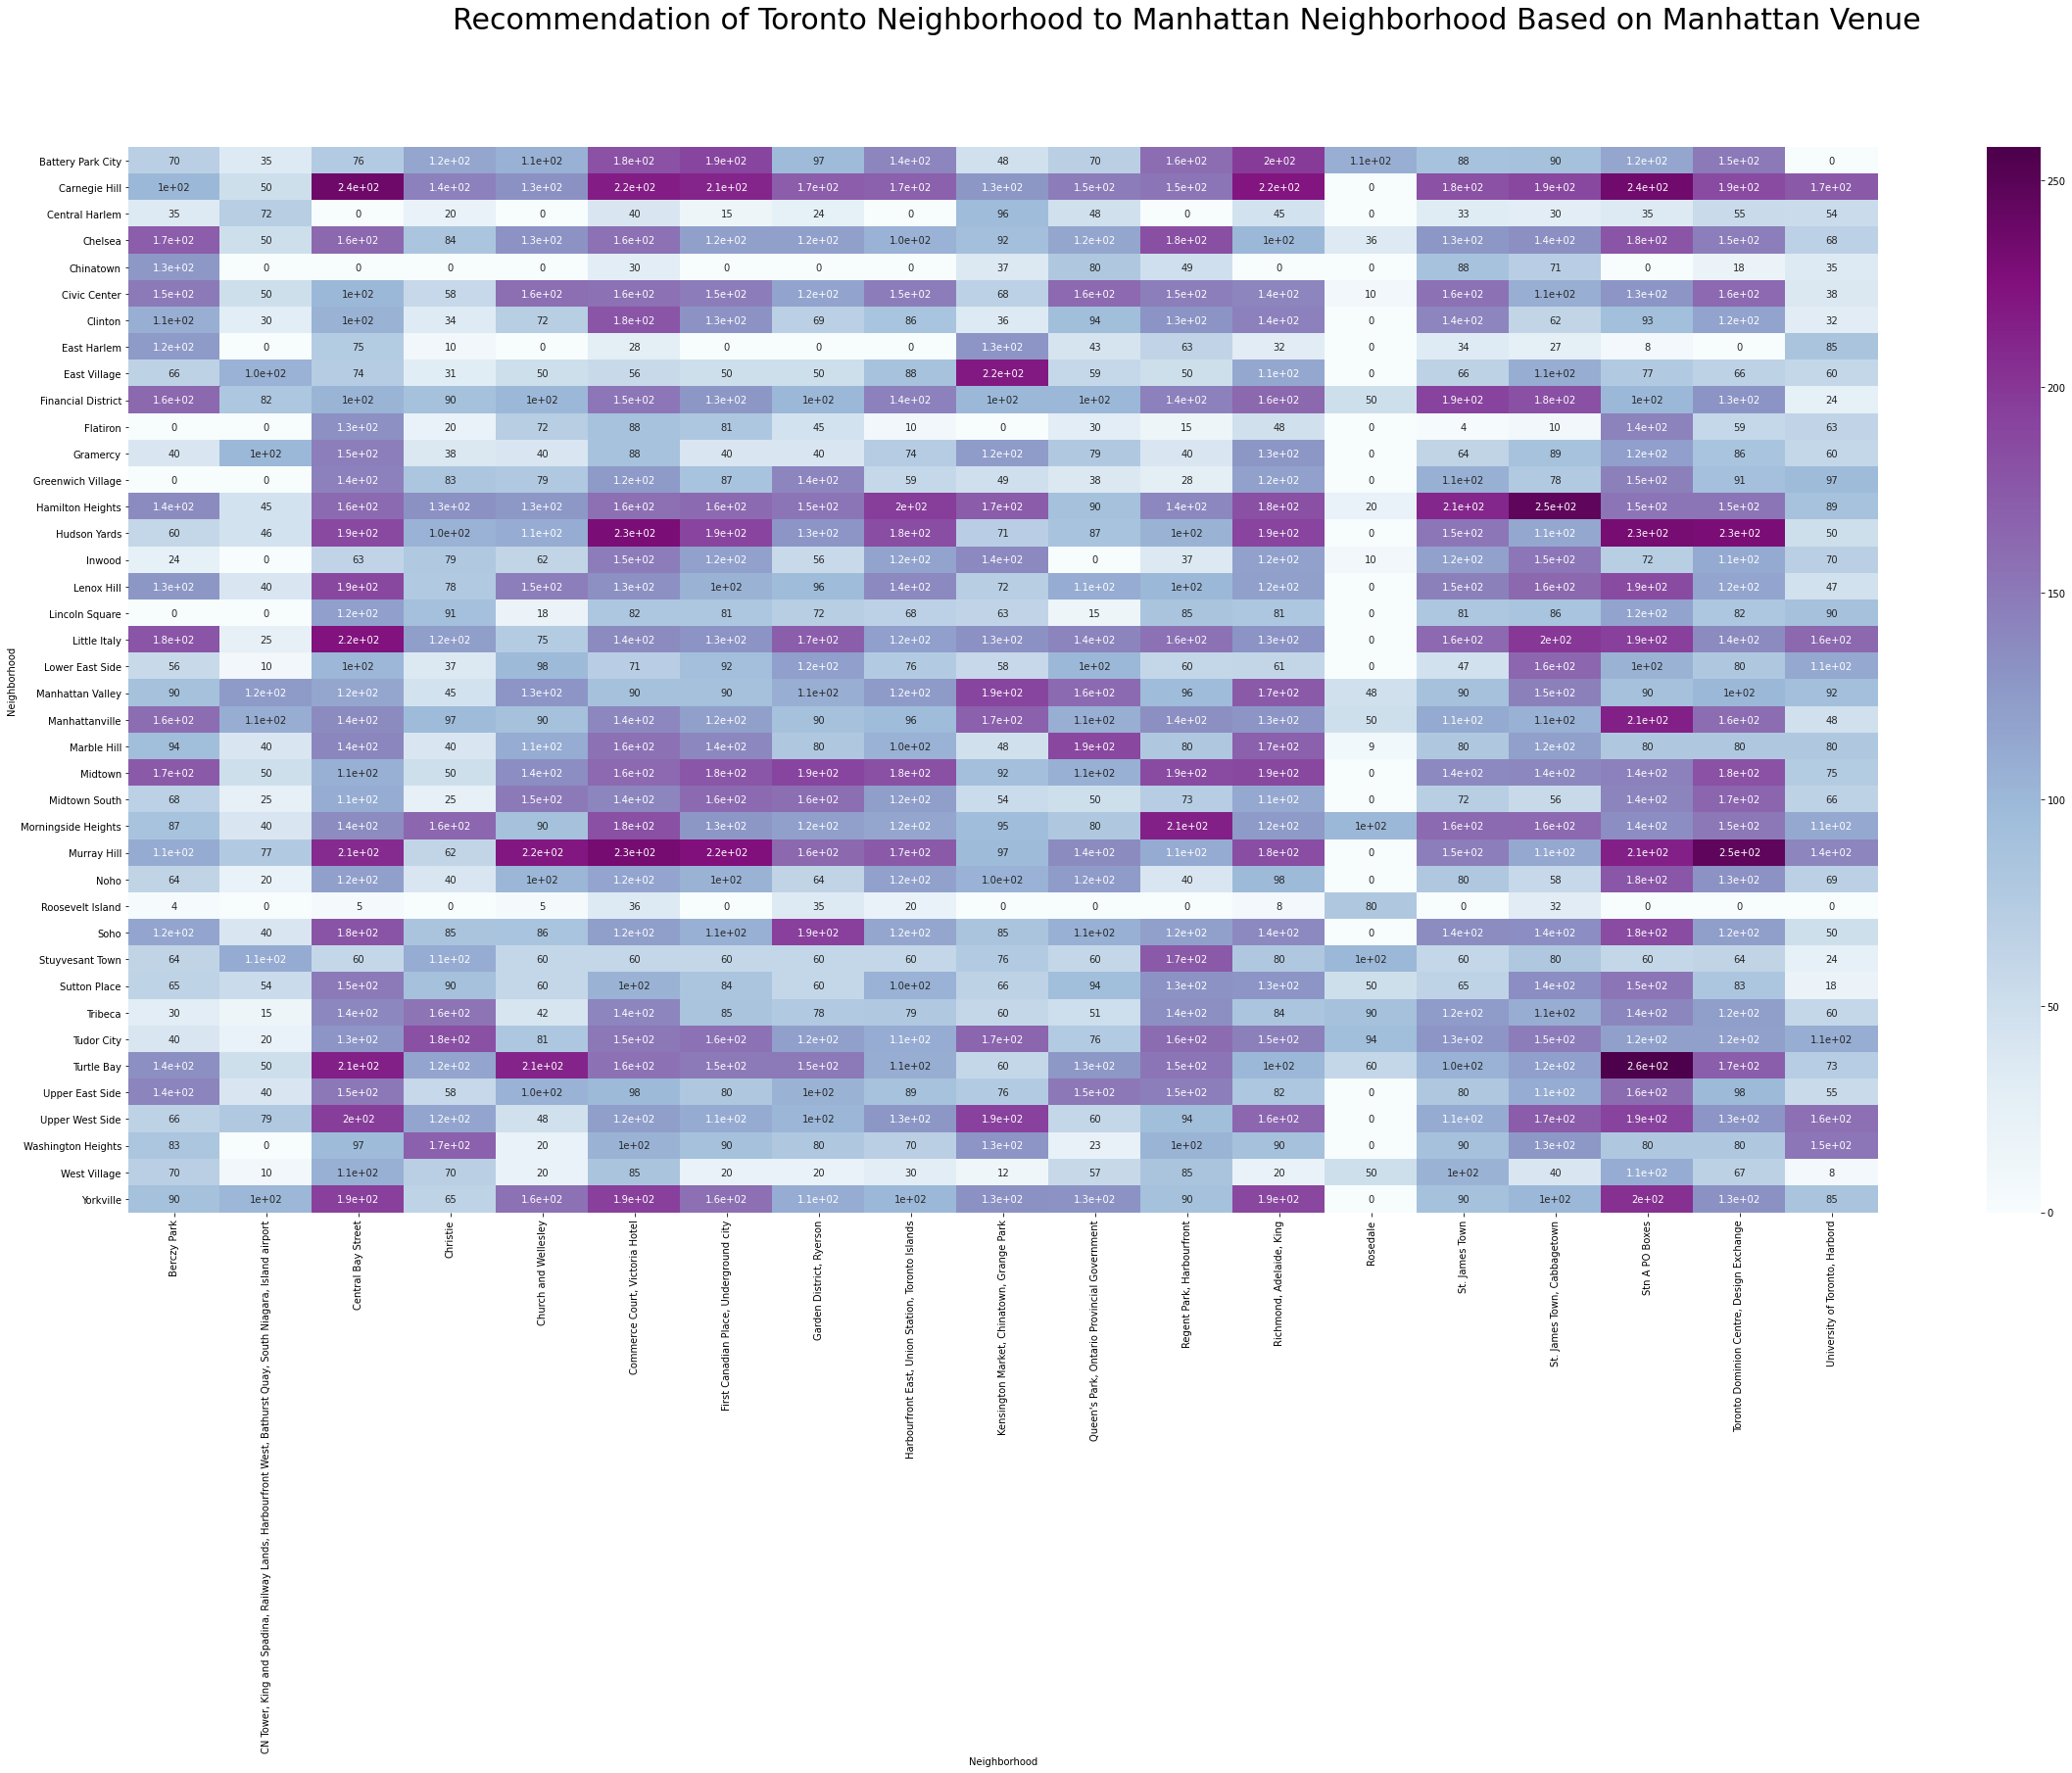

In [25]:
# plotting the heat map
fig, ax = plt.subplots(figsize=(40,20))
fig.suptitle('Recommendation of Toronto Neighborhood to Manhattan Neighborhood Based on Manhattan Venue', fontsize=30)
plt.xlabel('Toronto Neighborhood')
plt.ylabel('Manhattan Neighborhood')
sns.heatmap(mtCross, annot=True, cmap="BuPu")

## Step 9: How to understand the heat map

<h3>Without building a GUI that allows users to search for their neighborhood and the system automatically output the top 3 Toronto neighborhoods, I am going to select a few examples and explain how to interpret the heat map.</h3>

<h3>
First, user will look at the Y-axis to select the neighborhood that he/she currently reside. Second, user will look at that row and pick the cell will darkest color (or highest value). Lastly, user will need to go down to the bottom and check out the name of the neighborhood in Toronto. 

    Example #1: Bob lives in <b>Chinatown</b> (the 5th row on the Y-axis). The best neighborhood in Toronto to live in is <b>Berczy Park</b>. In fact, based on Google map, Toronto's Chinatown is couple streets off the center of Berzy Park.

    Example #2: Jody lives in <b>Soho</b> (the 11th row from the bottom up on the Y-axis), a place with many high-end shopping places. The best neightborhood in Toronto to live in is <b>Garden District, Reyerson</b>, which is a place surrounded by shopping complexes. 
    
</h3>

# END of report here, for more information, please refer to the actual reports. 


# Thank you